# Comparison of machine learning methods applied to birdsong element classification 

## Introduction
This Jupyter notebook reproduces figures from a study that compares different machine learning algorithms applied to the classification of birdsong elements (in preparation). The manuscript provides more detail, but I outline the motivation here for context.

### Songbirds provide a model system for the study of learned vocalizations.
Like humans, songbirds learn to vocalize during a critical period in development. During that critical period, they require social interactions, sensory feedback, and practice to learn their vocalizations--again, just like humans. Songbirds have a network of brain areas dedicated to learning and producing their song, known as the song system. These brain areas occur only in songbirds, not in birds that do not learn their song. At the same time, the bird brain contains most of the major regions found in the human brain, and studies of songbirds have changed our understanding of certain brain areas, e.g., the basal ganglia. Because of these shared behaviors and brain areas, songbirds provide an excellent model system through which we can understand how the brain learns and produces motor skills like speech that are learned during a critical period in development.
### Machine-learning methods for labeling elements of song
Each bird’s song consists of repeated elements referred to as “syllables”:
<img src="./static/spect_birdsong.png" width=800px>
**Figure 1. Spectrogram of Bengalese finch song.** _Letters below the time axis, e..g, "i","a","b",..., are labels for syllables, discrete elements of song separated by brief silent intervals. Frequency (kHz) on the y axis and time on the x axis._

Each individual has a unique song which usually bears some similarity to the song of the bird that tutored it, but is not a direct copy. To analyze song, experimenters label syllables by hand. However, songbirds produce thousands of songs a day, more than can be labeled.

In order to deal with this mountain of data, some labs have developed automated analyses of birdsong. One popular approach scores songs based on similarity of spectrograms, without labeling syllables (Tchernichovski et al.,2000). Another method uses semi-automated clustering to label syllables, and then measures changes in acoustic and temporal structure of song over days using a distance metric (Wu, Thompson, et al., 2008). Other approaches make use of standard supervised learning algorithms to classify syllables, such as hidden Markov Models (Kogan and Margoliash, 1998). While code for some of these automated analyses is freely available, and there are some repositories of song on-line, to my knowledge almost no work has been done to compare the different methods.    

I set out to compare methods using one species, the Bengalese finch. This species is of interest for several reasons. For example, Bengalese finches depend heavily on auditory feedback throughout life to maintain their vocalizations, much like humans (Sober and Brainard, 2009, and references therein). In addition, their song tends to have relatively easy-to-quantify acoustic features (e.g., many of the syllables are "low entropy", having a pitchy, whistle-like timbre). Several previously-published studies or open-sourced libraries have applied various machine learning techniques to Bengalese finch song, including:  support vector machines (SVMs) (Tachibana et al. 2014), and k-Nearest Neighbors (kNNs) (http://www.utsa.edu/troyerlab/software.html). Again, no study has compared these methods with open-source code and freely shared data.

### Rationale
Here I compare the accuracy and amount of training data required for SVMs and kNNs. My criteria for the "best" algorithm is one which yields the highest accuracy across syllables, i.e., labels, and does so with the smallest amount of training data. To machine learning researchers, it might seem like a foregone conclusion that SVMs would perform better than kNNs, so let me explain why. My initial experiments sought to reproduce the results of Tachibana et al. 2014, using a linear SVM. I found impaired accuracy for some individual birds' songs. This led me to test methods that can yield non-linear decision boundaries, such as kNN, inspired by the Troyer lab's approach (http://www.utsa.edu/troyerlab/software.html). Ultimately, as I show below, I find that SVMs yield the highest accuracy with the least amount of training data, if a non-linear kernel is used, along with the features I found that improved accuracy.

## Results
### Set up notebook and load results

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%run load_results_linsvm_svmrbf_and_knn.py

### SVM-RBF and k-NN yield higher accuracy with less training data than linear SVM
The main result of this paper is presented in figure 2. It shows that the average accuracy across classes, i.e. song syllables, was higher for k-NN and for SVM with a non-linear kernel than for linear SVM. (The non-linear kernel is a radial basis function, so the classifier will be abbreviated SVM-RBF). The validation curves for k-NN (blue line) and SVM-RBF (black line) rise more quickly than the curve for linear SVM (red line), indicating they achieve higher accuracy with less training data. Also notice that all the curves reach an asymptote, and that for three of four birds, both k-NN and SVM-RBF achieve higher accuracy at this asymptote than linear SVM. For bird 4 (lower right axis), linear SVM eventually achieved higher accuracy than k-NN, given enough training data, but never reached the accuracy of the SVM-RBF classifier.


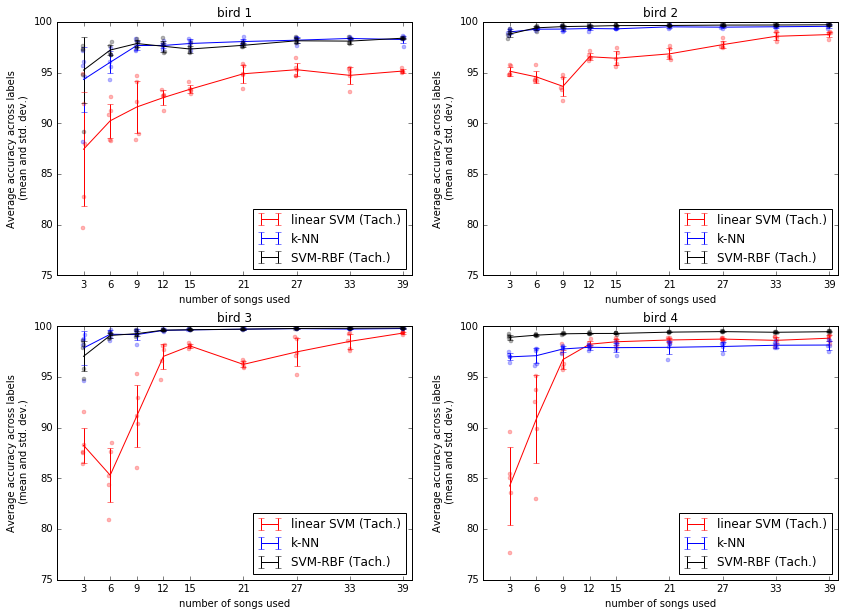

In [3]:
#plot lin-SVM, SVM-RBF, and k-NN all together on same graph
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    
    #linsvm
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['linsvm_test_avg_acc_mn'],
                 yerr=results['linsvm_test_avg_acc_std'],
                 fmt='-r',label='linear SVM (Tach.)')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)  
        
    #knn
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['knn_test_avg_acc_mn'],
                 yerr=results['knn_test_avg_acc_std'],
                 fmt='-b',label='k-NN')        
    knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)
    
    #svm-rbf
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['svm_Tach_test_avg_acc_mn'],
                 yerr=results['svm_Tach_test_avg_acc_std'],
                 fmt='-k',label='SVM-RBF (Tach.)')
    svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_Tach_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)
    
    plt.title(bird_name)
    plt.ylim((75,100))
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('all_algos.png', bbox_inches='tight')

**Figure 2. Validation curves showing accuracy vs. number of songs used to train classifiers.** *Y axis: average accuracy across labels, x axis: number of songs used to train the classifiers.* Points are accuracy for each fold of 5-fold cross validation. Validation curves are mean, and error bars are standard deviation across five folds. Red line: linear support vector machine (linear SVM); blue line: k-Nearest Neighbors (k-NN); black line: support vector machine with radial basis function as kernel (SVM-RBF). Note that accuracy is average accuracy across classes, i.e., song syllables.

As explained in the Methods section, accuracy was estimated with cross validation. Briefly: random samples were drawn from the training data and accuracy was measured on a completely separate set of testing data. Importantly, the number of samples in the testing data set was roughly on the order of the number of syllables that are hand-labeled for a typical songbird behavioral experiment. (Some previous studies have estimated accuracy for large data sets by bootstrapping from a smaller set of hand-labeled testing data.) Note that the comparison uses accuracy averaged across classes as a metric, because the ideal case would be to have each type of syllable classified perfectly. Note also that classifiers were trained with a number of songs instead of number of samples, because it is typical for a songbird reseacher to label complete songs instead of labeling e.g., 100 samples or "sixty seconds" of syllables. Each time a Bengalese Finch sings its song, it may sing a varying number of syllables. Hence one set of three songs drawn at random from the training data might have a different number of samples than another set. This difference in number of training samples accounts for some of the variance in accuracy scores, but k-NN and SVM-RBF clearly achieve higher accuracy than linear SVM in spite of this added variance.

It is also important to note that the k-NN classifier used a distinct set of features from those used in [TACH2014]_ because of concerns that the number of dimensions would impair k-NN accuracy. (In high-dimensional spaces, everything is close to everything, so the distances used by k-NN to determine nearest neighbor become uninformative, see [BEYER1999]_.) Instead, the k-NN algorithm used a small set of acoustic parameters that are commonly measured in songbird research, in addition to features from neighboring syllables that greatly improved the accuracy of the algorithm. These features from neighboring syllables are schematized in figure 3. The SVM-RBF classifier used the exact same features as the linear SVM. Experiments below address the question of whether the differences between classifiers shown in Fig.2 arise from a difference in features used or a difference in the classifiers themselves.

<img src="./static/features.png" width=600px>
**Figure 3. Duration features of preceding and following syllables and silent gaps that were added to the vector of features representing each syllable.**

## Intro syllables impair the accuracy of linear SVMs
The result in Fig.2 was suprising, given the previously reported accuracy for linear SVMs applied to Bengalese finch song. One potential cause for the impaired accuracy of the linear SVM method is the presence in song of “introductory notes”, low-amplitude, high-entropy syllables that often occur at the start of song, hence their name. Examples are shown in Fig.4. Because these syllables have low amplitude, it can be hard to detect their onset and offset, so the distribution of their duration will have much more variance than other syllabes. Likewise because they are high entropy, any feature derived from the spectrum will also be more variable. For example, measuring the "pitch" of an intro syllable by finding the peak in its power spectrum would yield wildly varying values, because there is no consistent peak to measure across renditions of the syllable. These sources of variability probably make it harder to separate intro syllables from other types.

<img src="./static/spect_birdsong_intro_notes.png" width=600px>
**Figure 4. Introductory notes are low-amplitude noisy syllables that often occur at the start of song** _Red boxes indicate introductory notes._

The next experiment determined whether removing intro syllables from the training and test sets would rescue the accuracy of the linear SVM. For the song of the birds used in this study, removing intro syllables greatly increased accuracy, as shown in Fig.5. Note that this result is consistent with the findings of [TACH2014]_. In their final set of experiments they found that the syllables most likely to be misclassified were those at the beginning and end of song, i.e., intro syllables. 

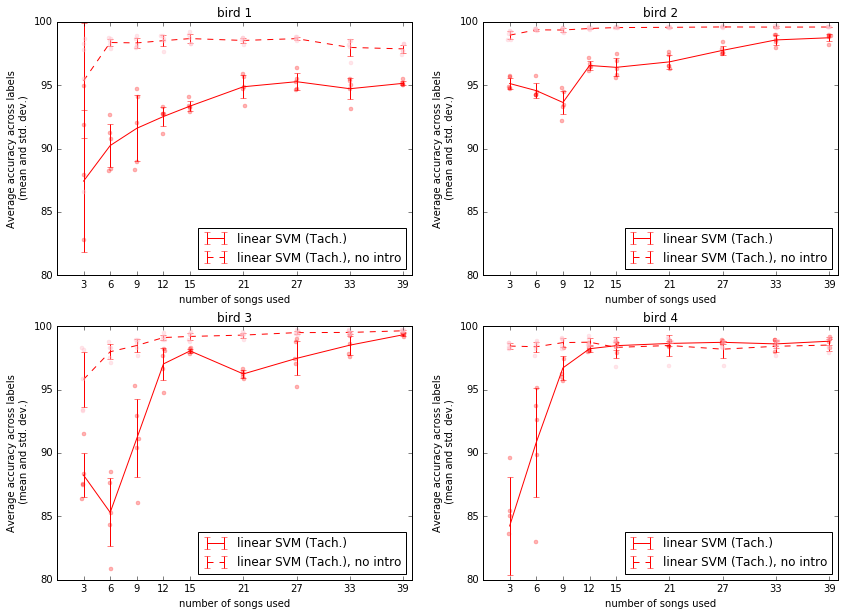

In [4]:
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,results['linsvm_test_avg_acc_mn'],yerr=results['linsvm_test_avg_acc_std'],fmt='-r',label='linear SVM (Tach.)')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,results['linsvm_test_no_intro_avg_acc_mn'],yerr=results['linsvm_test_no_intro_avg_acc_std'],fmt='--r',label='linear SVM (Tach.), no intro')
    linsvm_no_intro_avg_acc = np.asarray(results['linsvm_test_no_intro_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_no_intro_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, '.', alpha=0.4, markersize=8, color='pink')
    ax.set_ylim([80,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('linsvm_avg_acc_without_intro.png', bbox_inches='tight')

**Figure 5. Accuracy vs. number of songs used to train linear SVM, with intro syllables removed from training and test sets.** _Y axis: average accuracy across labels, x axis: number of songs used to train the linear SVM._ Removing intro syllables greatly increased accuracy for three of four birds.

### When using the same set of features to train all models, SVM-RBF outperforms k-NN that in turn outperforms linear SVM 

The results in Fig.2 showed that k-NN and SVM-RBF can yield higher average accuracy than linear SVM. However, the feature set for training the k-NN differed from the feature set for the SVM classifiers. As described above, a different feature set was used for k-NN because of concerns that the 536-dimensional feature vector would yield poor results (see [BEYER1999] for an in-depth study of how the number of features affects k-NN accuracy).

This leaves unanswered the question of whether differences in accuracy are due to the features used, or due to the ability of the algorithms to fit models to the feature space (or some combination of both). To address this question, the same approach was used to compare all three algorithms, but this time classifiers were trained with a set of 20 acoustic features from [TACH2014]. For all 4 birds tested, SVM-RBF acheived higher average accuracy with less training data than k-NN, and k-NN outperformed linear SVM, as shown in Fig.6.

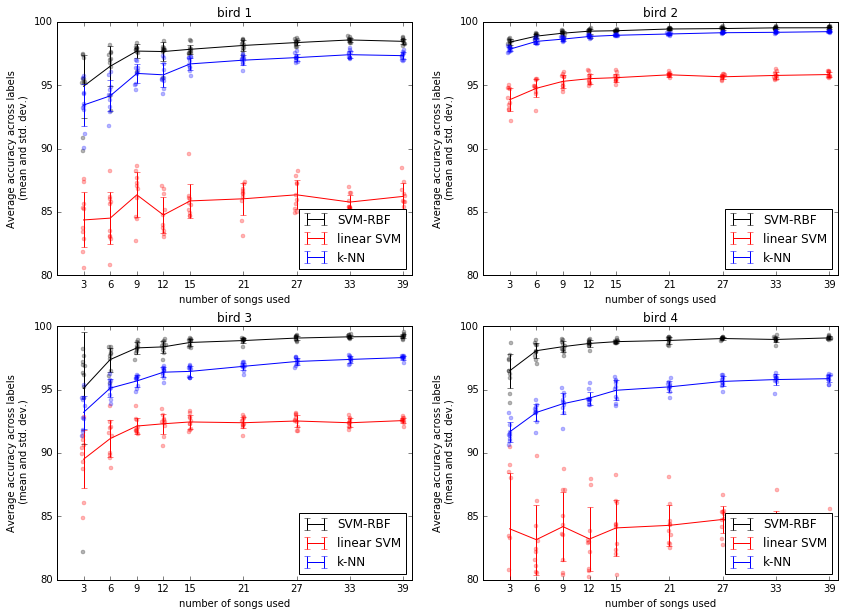

In [5]:
response = urllib.request.urlopen('http://www.nicholdav.info/static/same_ftrs_results_dict.json').read()
same_ftrs_results_dict = json.loads(response.decode('utf-8'))
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = same_ftrs_results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,results['svm_test_avg_acc_mn'],
                 yerr=results['svm_test_avg_acc_std'],
                 fmt='-k',label='SVM-RBF')
    svm_avg_acc = np.asarray(results['svm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,results['linsvm_test_avg_acc_mn'],
                 yerr=results['linsvm_test_avg_acc_std'],
                 fmt='-r',label='linear SVM')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['knn_test_avg_acc_mn'],
                 yerr=results['knn_test_avg_acc_std'],
                 fmt='-b',label='k-NN')
    knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)
    ax.set_ylim([80,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('svmrbf_linsvm_knn_same_ftrs_avg_acc_by_song.png', bbox_inches='tight')

**Figure 6. Accuracy v. number of songs used to train linear SVM, k-NN, and SVM-RBF models, using set of 20 acoustic features from Tachibana et al. 2014 to train all models** _Y axis: average accuracy across labels, x axis: number of songs used to train._

I also tested the accuracy of the models when all three were trained with the features I used above with k-NN.

In [ ]:
response = urllib.request.urlopen('http://www.nicholdav.info/static/knn_ftrs_results_dict.json').read()
knn_ftrs_results_dict = json.loads(response.decode('utf-8'))
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = knn_ftrs_results_dict[results_key]
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['svm_test_avg_acc_mn'],
                 yerr=results['svm_test_avg_acc_std'],
                 fmt='-k',label='SVM-RBF')
    svm_Tach_avg_acc = np.asarray(results['svm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_Tach_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['linsvm_test_avg_acc_mn'],
                 yerr=results['linsvm_test_avg_acc_std'],
                 fmt='-r',label='linear SVM')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)
    plt.errorbar(NUM_SONGS_TO_TEST,results['knn_test_avg_acc_mn'],
                 yerr=results['knn_test_avg_acc_std'],
                 fmt='-b',label='k-NN')
    knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)
    ax.set_ylim([80,100])
    plt.title(bird_name)
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)
plt.savefig('svmrbf_linsvm_knn_knn_ftrs_avg_acc_by_song.png', bbox_inches='tight')

**Figure 7. Accuracy v. number of songs used to train linear SVM, k-NN, and SVM-RBF models, using features originally designed for k-NN to train all models** _Y axis: average accuracy across labels, x axis: number of songs used to train._

## Conclusion
The results suggest SVM-RBF provides the highest accuracy across different birds' songs. For three of four birds, labeling as few as fifteen songs by hand provides enough training data to achieve greater than 99.2% average accuracy with SVM-RBF. This is approximately 40 seconds of song (assuming 50 milliseconds per syllable and 50 syllables per song), in comparison to previous papers that reported using a minute of song to achieve such accuracies.
The success of SVM-RBF is likely because the kernel allows for non-linear decision boundaries that can separate more variable types of syllables, such as the low-amplitude, high entropy "intro" syllables.
Further experiments should determine how well these algorithms deal with the presence of sounds that are not part of song, e.g., calls, movement of the bird on its perch, etc. Such experiments are necessary to further reduce the amount of work required on the part of the experimenter. I expect that the SVM-RBF will succeed in the face of these non-songbird elements as well. As the results above demonstrate, it is important to actually test how the algorithms compare with each other on varied data sets, and to present the results and code used to obtain those results in as accessible a manner as possible.

## Supplementary figures
### Plots of accuracy of classifiers with both testing error and also training error

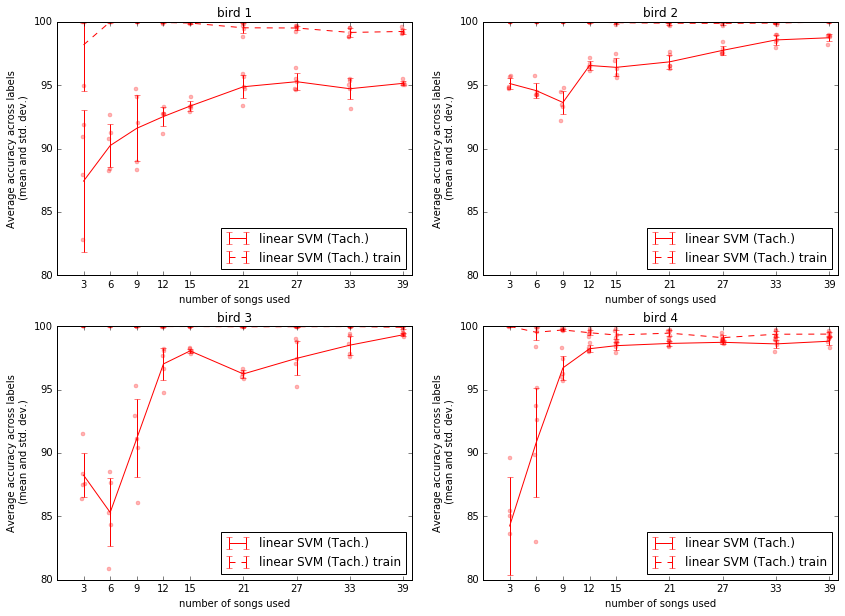

In [6]:
#plot lin-SVM w/test error and training error
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    
    #linsvm
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['linsvm_test_avg_acc_mn'],
                 yerr=results['linsvm_test_avg_acc_std'],
                 fmt='-r',label='linear SVM (Tach.)')
    linsvm_avg_acc = np.asarray(results['linsvm_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)

    #linsvm train error
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['linsvm_train_avg_acc_mn'],
                 yerr=results['linsvm_train_avg_acc_std'],
                 fmt='--r',label='linear SVM (Tach.) train')
    linsvm_avg_acc_train = np.asarray(results['linsvm_train_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = linsvm_avg_acc_train[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'r.', alpha=0.3, markersize=8)

    plt.title(bird_name)
    plt.ylim((80,100))
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)

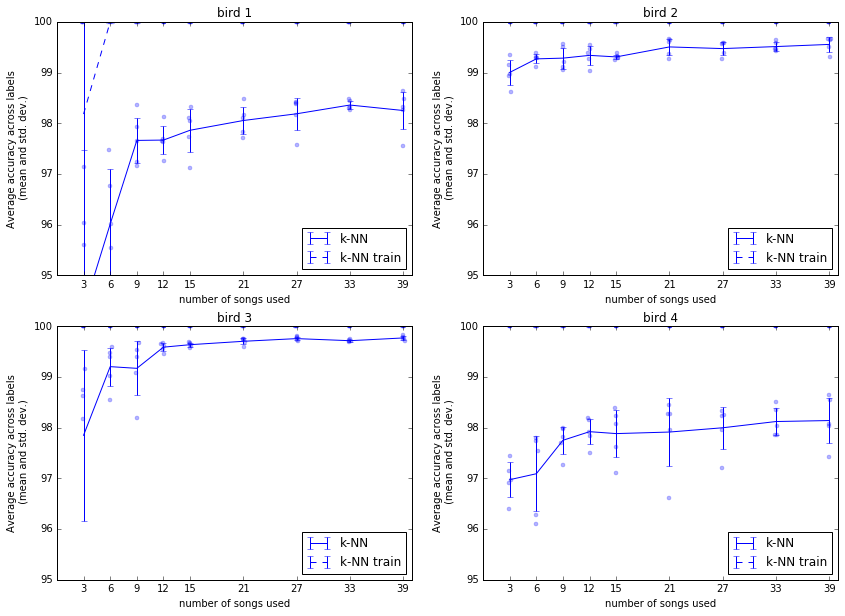

In [7]:
#plot k-NN test and training acc
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
          
    #knn
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['knn_test_avg_acc_mn'],
                 yerr=results['knn_test_avg_acc_std'],
                 fmt='-b',label='k-NN')        
    knn_avg_acc = np.asarray(results['knn_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)
        
    #knn train error
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['knn_train_avg_acc_mn'],
                 yerr=results['knn_train_avg_acc_std'],
                 fmt='--b',label='k-NN train')        
    knn_avg_acc_train = np.asarray(results['knn_train_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = knn_avg_acc_train[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3, markersize=8)

    plt.title(bird_name)
    plt.ylim((95,100))
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)

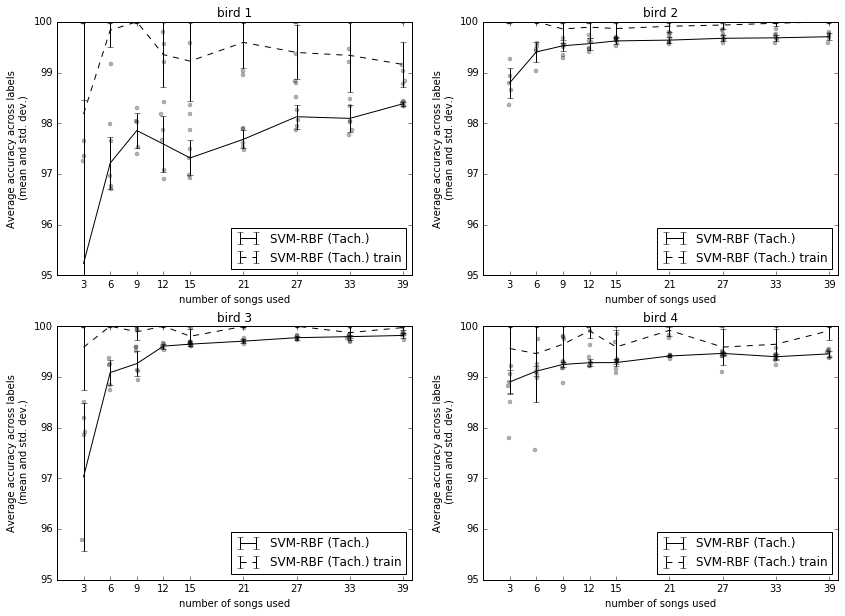

In [9]:
#plot SVM w/test error and training error
fig = plt.figure()
fig.set_size_inches(14,10)
ax=[]
for val,bird_name in enumerate(BIRD_NAME_LIST):
    pos = val+1
    ax = plt.subplot(2, 2, pos)
    results_key = BIRD_NAMES_DICT[bird_name]
    results = results_dict[results_key]
    
    #svm-rbf
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['svm_Tach_test_avg_acc_mn'],
                 yerr=results['svm_Tach_test_avg_acc_std'],
                 fmt='-k',label='SVM-RBF (Tach.)')
    svm_Tach_avg_acc = np.asarray(results['svm_Tach_test_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_Tach_avg_acc[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)

    #svm-rbf train error
    plt.errorbar(NUM_SONGS_TO_TEST,
                 results['svm_Tach_train_avg_acc_mn'],
                 yerr=results['svm_Tach_train_avg_acc_std'],
                 fmt='--k',label='SVM-RBF (Tach.) train')
    svm_Tach_avg_acc_train = np.asarray(results['svm_Tach_train_avg_acc'])
    for ind,x_tick in enumerate(NUM_SONGS_TO_TEST):
        y = svm_Tach_avg_acc_train[:,ind]
        x = np.random.normal(x_tick,0.08, size=len(y))
        plt.plot(x, y, 'k.', alpha=0.3, markersize=8)

    plt.title(bird_name)
    plt.ylim((95,100))
    plt.xticks(NUM_SONGS_TO_TEST)
    plt.xlabel('number of songs used')
    plt.ylabel('Average accuracy across labels\n (mean and std. dev.)')
    plt.legend(loc=4)